In [16]:
import xarray as xr
from glob import glob
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, zoomed_inset_axes
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import numpy as np
from xgcm import Grid
import cmocean.cm as cmo


In [49]:
# open AVISO data
ds = xr.open_dataset('/g/data/fu5/eac/20year_run_Junde/AVISO/2022/nrt_global_allsat_phy_l4_20220614_20220620.nc')
# open OISST data
sst = xr.open_dataset('/g/data/ua8/NOAA_OISST/AVHRR/v2-1_modified/oisst_avhrr_v2-1_2022.nc')


In [53]:
# choose time for SST data
timeSel = '20-06-2022'
sst = sst.sel(time=timeSel)

In [54]:
sst

<xarray.Dataset>
Dimensions:  (time: 1, lon: 1440, lat: 720, zlev: 1)
Coordinates:
  * time     (time) datetime64[ns] 2022-06-20T12:00:00
  * lon      (lon) float32 0.125 0.375 0.625 0.875 ... 359.1 359.4 359.6 359.9
  * lat      (lat) float32 -89.88 -89.62 -89.38 -89.12 ... 89.38 89.62 89.88
  * zlev     (zlev) float32 0.0
Data variables:
    anom     (time, zlev, lat, lon) float32 ...
    err      (time, zlev, lat, lon) float32 ...
    ice      (time, zlev, lat, lon) float32 ...
    sst      (time, zlev, lat, lon) float32 ...
Attributes: (12/39)
    CDI:                        Climate Data Interface version 1.9.8 (https:/...
    history:                    Final file created using preliminary as first...
    source:                     ICOADS, NCEP_GTS, GSFC_ICE, NCEP_ICE, Pathfin...
    institution:                NOAA/National Centers for Environmental Infor...
    Conventions:                CF-1.6, ACDD-1.3
    title:                      NOAA/NCEI 1/4 Degree Daily Optimum Interpolat...
    ...                         ...
    time_coverage_end:          2022-01-01T23:59:59Z
    metadata_link:              https://doi.org/10.25921/RE9P-PT57
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    comment:                    Data was converted from NetCDF-3 to NetCDF-4 ...
    sensor:                     Thermometer, AVHRR
    CDO:                        Climate Data Operators version 1.9.8 (https:/...

In [55]:
# subset data to speed up processing/loading
aviso_s = ds.sel(latitude=slice(-50,-15),longitude=slice(130,170))
sst_s = sst.sel(lat=slice(-50,-15),lon=slice(130,170))

/local/m68/deg581/tmp/ipykernel_38108/3912703198.py:71: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  axins.outline_patch.set_visible(False)


<Figure size 432x288 with 0 Axes>

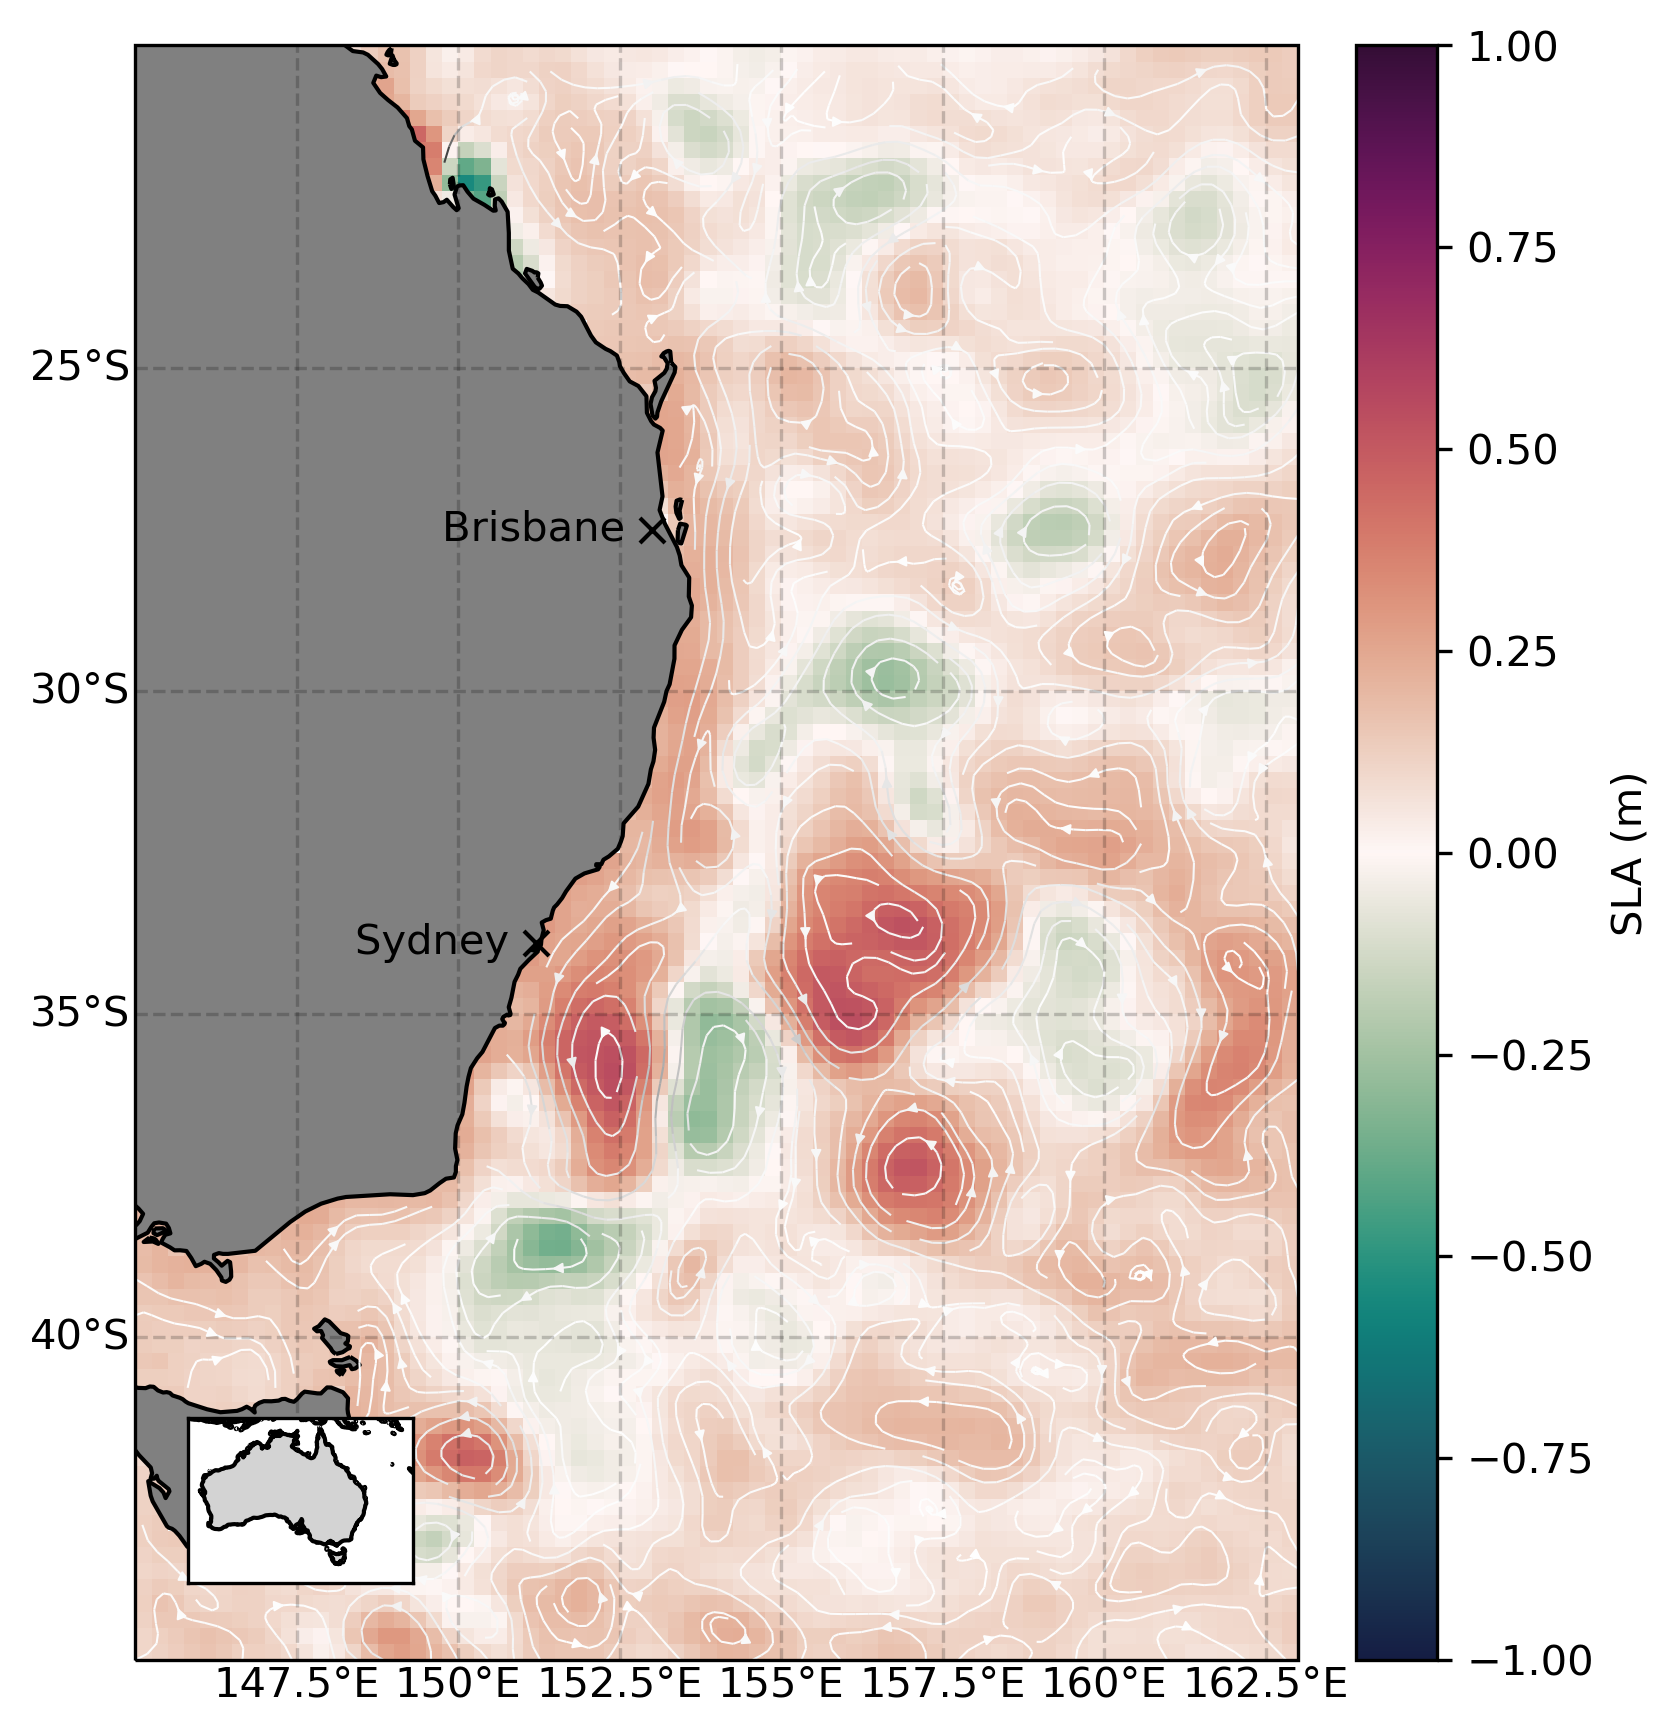

In [39]:

# gs to make a 4 row, 7 col plot
gs = gridspec.GridSpec(nrows=1,ncols=1,wspace=0.25, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[5,9],dpi=300)
ax = None


clims=(-1,1)
pcol_kwargs={'cmap':'cmo.curl','vmin':clims[0],'vmax':clims[1]}

ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax.set_extent([145, 163, -45, -20])
feature = ax.add_feature(cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none', name='coastline'), edgecolor='black',facecolor='gray')

im = aviso_s.sla.plot(ax=ax,x='longitude',y='latitude',add_colorbar=False,**pcol_kwargs) 

aviso_s["umag"] = np.sqrt(aviso_s.ugos.isel(time=0).squeeze()**2+aviso_s.vgos.isel(time=0).squeeze()**2)
str_kwargs = {"color":aviso_s.umag.values,
              "linewidth":.5,
              "arrowsize":.5,
              "density":3,
              "cmap":"Greys",
             "transform":ccrs.PlateCarree()}
# str_kwargs = {"color":'0.6',
#               "linewidth":.5,
#               "arrowsize":.5,
#               "density":3,
#              "transform":ccrs.PlateCarree()}
st = ax.streamplot(aviso_s.longitude.values, aviso_s.latitude.values, aviso_s.ugos.isel(time=0).values.squeeze(), aviso_s.vgos.isel(time=0).values.squeeze(),**str_kwargs)



gl = ax.gridlines(draw_labels=True,
                 color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = True
gl.bottom_labels = True
# ax.text(0.01, 0.1, labelText, transform=ax.transAxes,fontsize=22, fontweight='bold', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.set_title('')
# ax[0].text(0.5, 1.05, 'Experiment layout',fontsize=14, fontweight='bold', va='center', ha='center', rotation='horizontal', transform=ax[0].transAxes)
ax.text(153,-27.5,'Brisbane  ',ha='right',va='center'), ax.plot(153,-27.5,marker='x',color='k')
ax.text(151.2,-33.9,'Sydney  ',ha='right',va='center'), ax.plot(151.2,-33.9,marker='x',color='k')

# add colorbar
cax = inset_axes(ax,
                 width="7%",  # width = 10% of parent_bbox width
                 height="100%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(1.05,0, 1, 1),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_ylabel('SLA (m)')

# add an inset map
axins = fig.add_axes([.16, 0.20, 0.15, 0.125], projection=ccrs.PlateCarree())
axins.set_extent([110, 165, -45, -8])
feature = axins.add_feature(cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none', name='coastline'), edgecolor='black',facecolor='lightgray')

gl = axins.gridlines(draw_labels=True,
                 color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
gl.xlines = False
gl.ylines = False
axins.outline_patch.set_visible(False)
axins.spines['right'].set_visible(True)
axins.spines['top'].set_visible(True)
axins.spines['bottom'].set_visible(True)
axins.spines['left'].set_visible(True)


/local/m68/deg581/tmp/ipykernel_38108/1922217421.py:79: DeprecationWarning: The outline_patch property is deprecated. Use GeoAxes.spines['geo'] or the default Axes properties instead.
  axins.outline_patch.set_visible(False)


Text(2, 1.0, 'SLA (m)')

<Figure size 432x288 with 0 Axes>

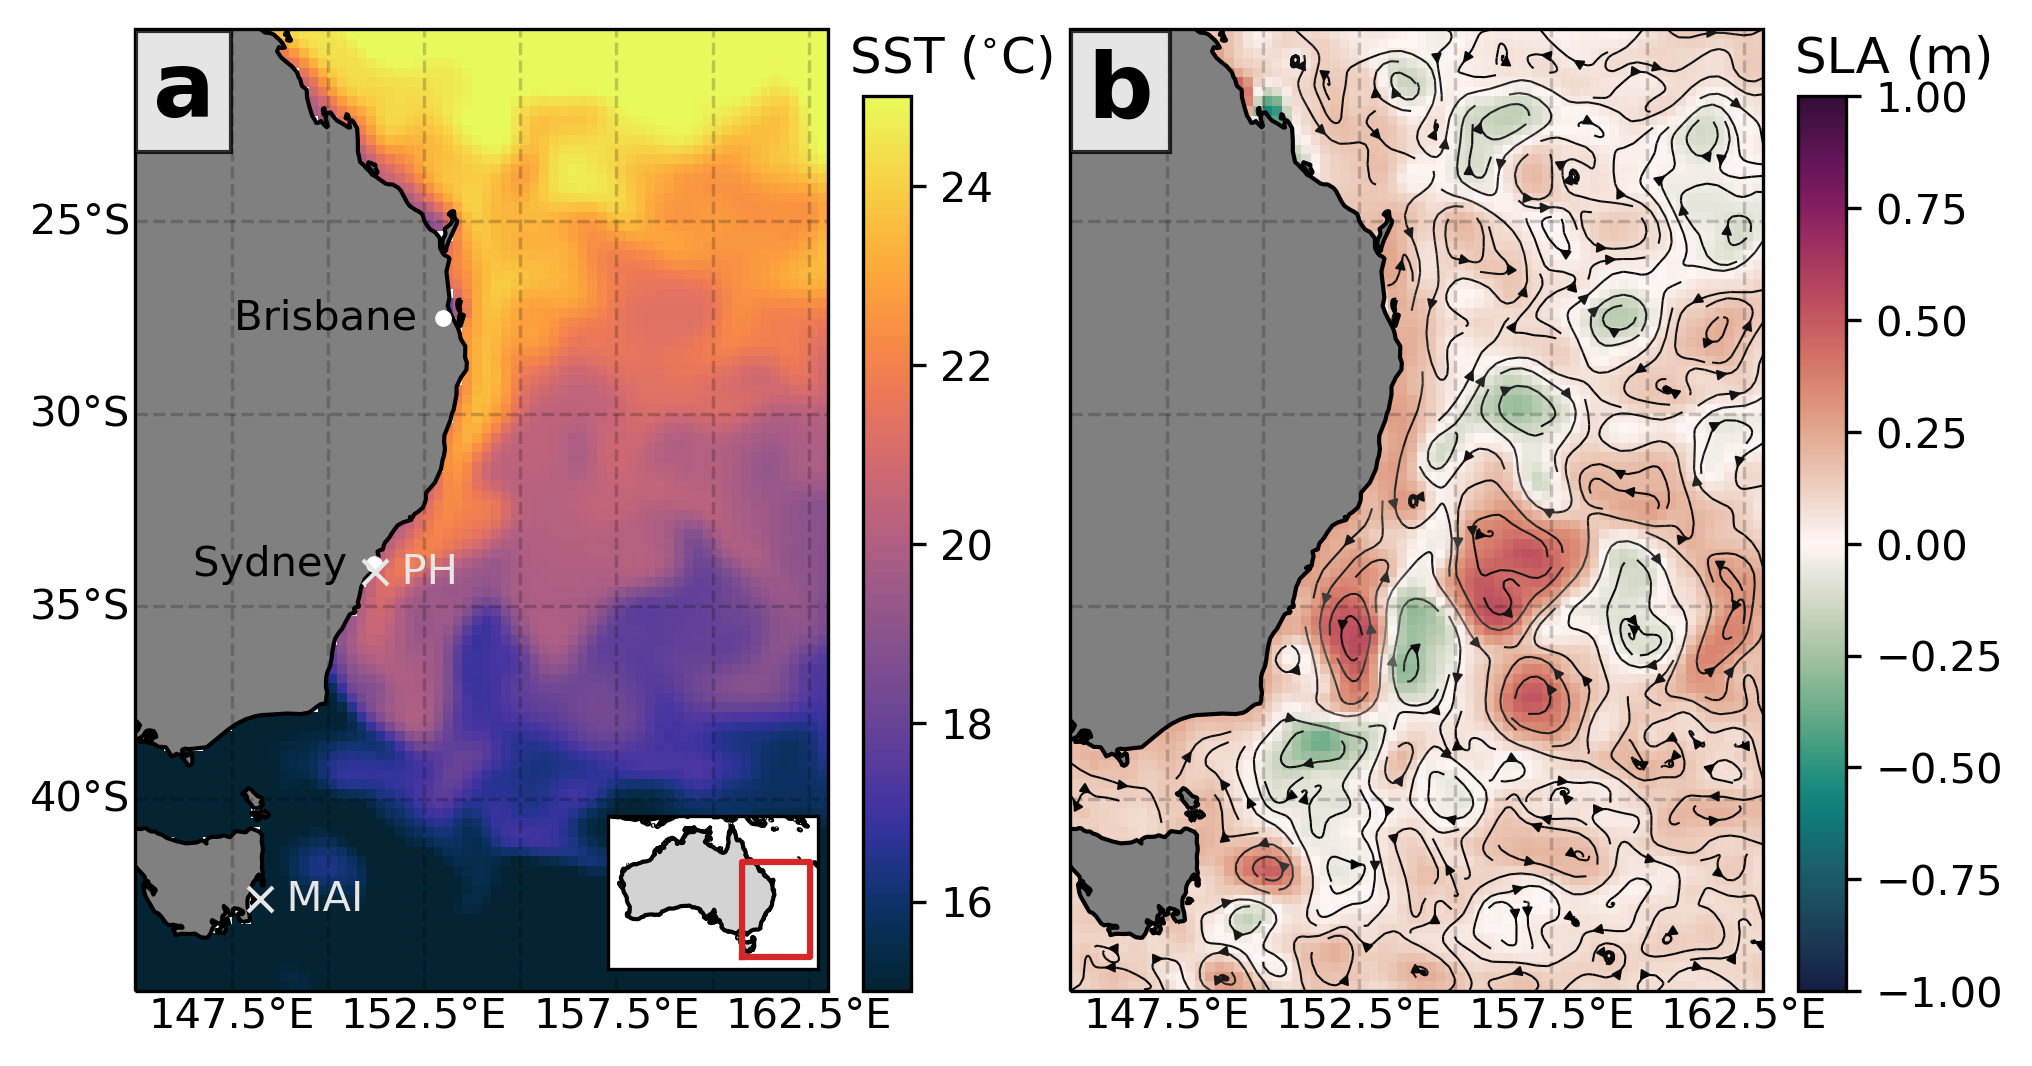

In [106]:

# gs to make a 4 row, 7 col plot
gs = gridspec.GridSpec(nrows=1,ncols=2,wspace=0.35, hspace=0.05)
plt.cla()
plt.clf()
fig = plt.figure(figsize=[7,10],dpi=300)
ax = None


clims=(15,25)
pcol_kwargs={'cmap':'cmo.thermal','vmin':clims[0],'vmax':clims[1]}
extent=np.array([145, 163, -45, -20])

ax = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
ax.set_extent(extent)
feature = ax.add_feature(cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none', name='coastline'), edgecolor='black',facecolor='gray')

im = sst_s.sst.plot(ax=ax,x='lon',y='lat',add_colorbar=False,**pcol_kwargs) 

# aviso_s["umag"] = np.sqrt(aviso_s.ugos.isel(time=0).squeeze()**2+aviso_s.vgos.isel(time=0).squeeze()**2)
# str_kwargs = {"color":aviso_s.umag.values,
#               "linewidth":.5,
#               "arrowsize":.5,
#               "density":3,
#               "cmap":"Greys",
#              "transform":ccrs.PlateCarree()}
# # str_kwargs = {"color":'0.6',
# #               "linewidth":.5,
# #               "arrowsize":.5,
# #               "density":3,
# #              "transform":ccrs.PlateCarree()}
# st = ax.streamplot(aviso_s.longitude.values, aviso_s.latitude.values, aviso_s.ugos.isel(time=0).values.squeeze(), aviso_s.vgos.isel(time=0).values.squeeze(),**str_kwargs)



gl = ax.gridlines(draw_labels=True,
                 color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = True
gl.bottom_labels = True
ax.text(0.025, 0.981, 'a', transform=ax.transAxes,fontsize=22, fontweight='bold',ha='left', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.set_title('')
# ax[0].text(0.5, 1.05, 'Experiment layout',fontsize=14, fontweight='bold', va='center', ha='center', rotation='horizontal', transform=ax[0].transAxes)
ax.text(153,-27.5,'Brisbane  ',ha='right',va='center'), ax.plot(153,-27.5,marker='.',color='w')
ax.text(151.2,-33.9,'Sydney  ',ha='right',va='center'), ax.plot(151.2,-33.9,marker='.',color='w')
# ax.text(151.194,-34.102,'  PHA',ha='left',va='center'), ax.plot(151.194,-34.102,marker='x',color='0.9')
# ax.text(151.216,-34.118,'  PHB',ha='left',va='center'), ax.plot(151.216,-34.118,marker='x',color='0.9')
ax.text(151.216,-34.118,'  PH',ha='left',va='center',color='0.9'), ax.plot(151.216,-34.118,marker='x',color='0.9')
ax.text(148.23,-42.6,'  MAI',ha='left',va='center',color='0.9'), ax.plot(148.23,-42.6,marker='x',color='0.9')
# add colorbar
cax = inset_axes(ax,
                 width="7%",  # width = 10% of parent_bbox width
                 height="100%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(1.05,0, 1, .93),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_title('  SST $(\!^\circ\!\mathrm{C})$',x=1.5)

# add an inset map
axins = fig.add_axes([.35, 0.33, 0.1, 0.09], projection=ccrs.PlateCarree())
axins.set_extent([110, 165, -45, -8])
feature = axins.add_feature(cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none', name='coastline'), edgecolor='black',facecolor='lightgray')
# boxLo,boxLa = calc_boxSpatial(truth,etaRange=etas,xiRange=xis)
# np.array([pt00lo, pt01lo, pt11lo, pt10lo, pt00lo])
#     boxLa = np.array([pt00la, pt01la, pt11la, pt10la, pt00la])
    
axins.plot(np.array([extent[0],extent[1],extent[1],extent[0],extent[0]]),np.array([extent[2],extent[2],extent[3],extent[3],extent[2]]),color='C3')
gl = axins.gridlines(draw_labels=True,
                 color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = False
gl.xlines = False
gl.ylines = False
axins.outline_patch.set_visible(False)
axins.spines['right'].set_visible(True)
axins.spines['top'].set_visible(True)
axins.spines['bottom'].set_visible(True)
axins.spines['left'].set_visible(True)


clims=(-1,1)
pcol_kwargs={'cmap':'cmo.curl','vmin':clims[0],'vmax':clims[1]}

ax = fig.add_subplot(gs[0,1], projection=ccrs.PlateCarree())
ax.set_extent([145, 163, -45, -20])
feature = ax.add_feature(cfeature.NaturalEarthFeature(category='physical',scale='50m',facecolor='none', name='coastline'), edgecolor='black',facecolor='gray')

im = aviso_s.sla.plot(ax=ax,x='longitude',y='latitude',add_colorbar=False,**pcol_kwargs) 

aviso_s["umag"] = np.sqrt(aviso_s.ugos.isel(time=0).squeeze()**2+aviso_s.vgos.isel(time=0).squeeze()**2)
str_kwargs = {"color":aviso_s.umag.values,
              "linewidth":.5,
              "arrowsize":.5,
              "density":2,
              "cmap":"Greys_r",
             "transform":ccrs.PlateCarree()}
# str_kwargs = {"color":'0.6',
#               "linewidth":.5,
#               "arrowsize":.5,
#               "density":3,
#              "transform":ccrs.PlateCarree()}
st = ax.streamplot(aviso_s.longitude.values, aviso_s.latitude.values, aviso_s.ugos.isel(time=0).values.squeeze(), aviso_s.vgos.isel(time=0).values.squeeze(),**str_kwargs)

gl = ax.gridlines(draw_labels=True,
                 color='black', alpha=0.2, linestyle='--')
gl.right_labels = False
gl.top_labels = False
gl.left_labels = False
gl.bottom_labels = True
ax.text(0.025, 0.981, 'b', transform=ax.transAxes,fontsize=22, fontweight='bold',ha='left', va='top', bbox=dict(facecolor='white',alpha=0.8))
ax.set_title('')


# add colorbar
cax = inset_axes(ax,
                 width="7%",  # width = 10% of parent_bbox width
                 height="100%",  # height : 50%
                 loc='lower left',
                 bbox_to_anchor=(1.05,0, 1, .93),
                 bbox_transform=ax.transAxes,
                 borderpad=0,
                 )
cbar = fig.colorbar(im, cax=cax)
cbar.ax.set_title('SLA (m)',x=2)
